In [ ]:
import pandas as pd
cal = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
steval = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
price = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv') 

Since the set of full training labels are released now, we can ignore "sales_train_validation" data set and proceed working with "sales_train_evaluation" instead. We will check some randomly selected id's trend now, just to get a view of how it is varying with time.

In [ ]:
import numpy as np
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

id_list = sorted(list(set(steval['id'])))
d_cols = [col for col in steval.columns if 'd_' in col]
x_1 = steval.loc[steval['id'] == id_list[0]].set_index('id')[d_cols].values[0][:200]
x_2 = steval.loc[steval['id'] == id_list[12]].set_index('id')[d_cols].values[0][300:500]
x_3 = steval.loc[steval['id'] == id_list[36]].set_index('id')[d_cols].values[0][600:800]
x_4 = steval.loc[steval['id'] == id_list[64]].set_index('id')[d_cols].values[0][1000:1200]
x_5 = steval.loc[steval['id'] == id_list[128]].set_index('id')[d_cols].values[0][1300:1500]
x_6 = steval.loc[steval['id'] == id_list[256]].set_index('id')[d_cols].values[0][1600:1800]
fig = make_subplots(rows=6, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=True, 
                         mode='lines', name="1st sample",
                         marker=dict(color="cadetblue")), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=True,
                         mode='lines', name="2nd sample",
                         marker=dict(color="firebrick")), row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=True,
                         mode='lines', name="3rd sample",
                         marker=dict(color="yellowgreen")), row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_4)), y=x_4, showlegend=True,
                         mode='lines', name="4th sample",
                         marker=dict(color="orangered")), row=4, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_5)), y=x_5, showlegend=True,
                         mode='lines', name="5th sample",
                         marker=dict(color="mediumpurple")), row=5, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_6)), y=x_6, showlegend=True,
                         mode='lines', name="6th sample", 
                         marker=dict(color="navy")), row=6, col=1)

fig.update_layout(height=1200, width=900, title_text="Observing some randomly chosen sales trend :")
fig.show()

By observation, we can spot intermittency in all the samples, especially in second and fourth samples, intermittency can be spotted very prominently (Y-axis value is dropping to zero quite frequently).

In [ ]:
steval.head()

We see that evaluation data set has columns from "d_1" till "d_1941". Since we need to get the result for next 28 days i.e. from "d_1942" till "d_1969", we can fill them up with zero values, initially.

In [ ]:
#For the remaining 28 days d1942 to d1969, filling with zero

import numpy as np
for i in range(1942,1970):
    col = 'd_' + str(i)
    steval[col] = 0
    steval[col] = steval[col].astype(np.int16)

Now, we will check the sizes of three datasets and reduce them to avoid getting memory allocation alert.

In [ ]:
#Check size
steval.info()

In [ ]:
#Check size
cal.info()

In [ ]:
#Check size
price.info()

We will now reduce the sizes of three datasets.

In [ ]:
# Taken from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
import numpy as np
def reduce_mem_usage(df):
   
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
reduce_mem_usage(steval)

In [ ]:
reduce_mem_usage(price)

In [ ]:
reduce_mem_usage(cal)

For day indicators (variables with prefix "d_") in "steval" data set, the values can be more conveniently handled if they are reshaped to put into rows instead of columns. Because in the next step, we will actually merge the "steval" dataset with two other data sets (calendar and prices); and notably, in "calendar" data set, the column "d" has "d_" prefixed values arranged in vertical format (unlike "steval" where they are arranged horizontally). So, we will apply "melt" function on "steval" which will unpivot the dataframe from wide format (horizontal) to long format (vertical). This will help in merging the data set with calendar data set. 

In [ ]:
sales = pd.melt(steval, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

Now, the sales dataframe looks like below, compact, easy to merge with Calendar data set matched on column "d".

In [ ]:
sales.head()

Next, we will merge calendar and price datasets with sales data to make it a single working data set.

In [ ]:
sales = pd.merge(sales, cal, on='d', how='left')
sales = pd.merge(sales, price, on=['store_id','item_id','wm_yr_wk'], how='left') 

Checking all the columns in our final working data set :

In [ ]:
sales.info()

We will encode the categorical variables to numericals. And for convenience, we will store their categories (a list) along with their codes (another list) in separate dictionaries, so that we can use them again during submission.

In [ ]:
#Encode categorical variables. Store the categories along with their codes
d_id = dict(zip(sales.id.cat.codes, sales.id))
d_item_id = dict(zip(sales.item_id.cat.codes, sales.item_id))
d_dept_id = dict(zip(sales.dept_id.cat.codes, sales.dept_id))
d_cat_id = dict(zip(sales.cat_id.cat.codes, sales.cat_id))
d_store_id = dict(zip(sales.store_id.cat.codes, sales.store_id))
d_state_id = dict(zip(sales.state_id.cat.codes, sales.state_id))

In [ ]:
#Removing "d_" prefix from the values of column "d"
sales.d = sales['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = sales.dtypes.index.tolist()
types = sales.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        sales[cols[i]] = sales[cols[i]].cat.codes

In [ ]:
#Dropping date column        
sales.drop('date',axis=1,inplace=True)

Now, we will introduce lags into this data set. I have introduced lags at a sequence {2^0,2^1,2^2,2^3,2^4,2^5}. You can introduce lags at some other sequence like {1,3,6,12,24,36} etc.

In [ ]:
lags = [1,2,4,8,16,32]
for lag in lags:
    sales['sold_lag_'+str(lag)] = sales.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

In [ ]:
#Combination of two vars with "sold" and their mean
sales['item_sold_avg'] = sales.groupby('item_id')['sold'].transform('mean').astype(np.float16)
sales['state_sold_avg'] = sales.groupby('state_id')['sold'].transform('mean').astype(np.float16)
sales['store_sold_avg'] = sales.groupby('store_id')['sold'].transform('mean').astype(np.float16)
sales['cat_sold_avg'] = sales.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
sales['dept_sold_avg'] = sales.groupby('dept_id')['sold'].transform('mean').astype(np.float16)

#Combination of three vars with "sold" and their mean
sales['cat_dept_sold_avg'] = sales.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
sales['store_item_sold_avg'] = sales.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
sales['cat_item_sold_avg'] = sales.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
sales['dept_item_sold_avg'] = sales.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
sales['dept_store_sold_avg'] = sales.groupby(['dept_id','store_id'])['sold'].transform('mean').astype(np.float16)

#Combination of four vars with "sold" and their mean
sales['store_cat_dept_sold_avg'] = sales.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
sales['store_cat_item_sold_avg'] = sales.groupby(['store_id','cat_id','item_id'])['sold'].transform('mean').astype(np.float16)

#Some more combinations can be incorporated here, but to avoid memory allocation warning, the above combinations would suffice 

In [ ]:
id_list = sorted(list(set(sales['id'])))
sold_avg_cols = [col for col in sales.columns if '_sold_avg' in col]
x_1 = sales.loc[sales['id'] == id_list[0]].set_index('id')[sold_avg_cols].values[0][:]
x_2 = sales.loc[sales['id'] == id_list[12]].set_index('id')[sold_avg_cols].values[0][:]
x_3 = sales.loc[sales['id'] == id_list[36]].set_index('id')[sold_avg_cols].values[0][:]
x_4 = sales.loc[sales['id'] == id_list[64]].set_index('id')[sold_avg_cols].values[0][:]
x_5 = sales.loc[sales['id'] == id_list[128]].set_index('id')[sold_avg_cols].values[0][:]
x_6 = sales.loc[sales['id'] == id_list[256]].set_index('id')[sold_avg_cols].values[0][:]
fig = make_subplots(rows=6, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=True, 
                         mode='lines+markers', name="First sample",
                         marker=dict(color="cadetblue")), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=True,
                         mode='lines+markers', name="Second sample",
                         marker=dict(color="firebrick")), row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=True,
                         mode='lines+markers', name="Third sample",
                         marker=dict(color="yellowgreen")), row=3, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_4)), y=x_4, showlegend=True,
                         mode='lines+markers', name="Fourth sample",
                         marker=dict(color="orangered")), row=4, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_5)), y=x_5, showlegend=True,
                         mode='lines+markers', name="Fifth sample",
                         marker=dict(color="mediumpurple")), row=5, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_6)), y=x_6, showlegend=True,
                         mode='lines+markers', name="Sixth sample", 
                         marker=dict(color="navy")), row=6, col=1)

fig.update_layout(height=1500, width=900, title_text="Observing some randomly chosen '_sold_avg' trends after applying lag:")
fig.show()

Now, we can spot some similarity. First, second, fourth, fifth samples show somewhat similar trend now. Third and sixth ones show similar trends as well.

Now, we will use **"rolling window"** and **"expanding window"** concepts where the sold-mean of a particular window size will be stored in two different variables. It is important to decide the size of rolling window (for getting Moving Average). Longer the rolling window size, smoother the rolling window mean estimates become. For deciding expanding window size, suppose, the number of increments between successive rolling windows is 1 period; then it partitions the entire data set into N = T – m + 1 subsamples (ref: the picture below)
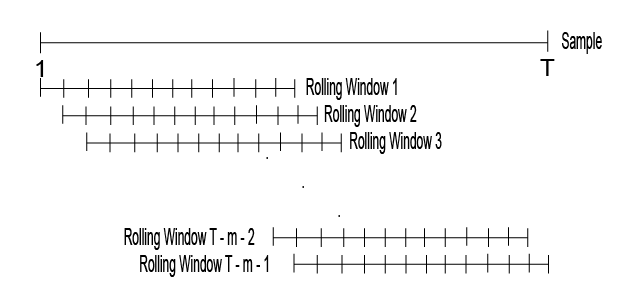

(pic taken from mathworks.com). Here, we have taken window size = 6 and expanding window size = 2 respectively.

In [ ]:
sales['rolling_sold_mean'] = sales.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=6).mean()).astype(np.float16)

In [ ]:
sales['expanding_sold_mean'] = sales.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

In [ ]:
#Clear some space
import gc
gc.collect()

In [ ]:
# Moving Average Trends
sales['daily_avg_sold'] = sales.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sold'].transform('mean').astype(np.float16)
sales['avg_sold'] = sales.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform('mean').astype(np.float16)
sales['selling_trend'] = (sales['daily_avg_sold'] - sales['avg_sold']).astype(np.float16)
sales.drop(['daily_avg_sold','avg_sold'],axis=1,inplace=True)

In [ ]:
# Since we introduced lags till 32 days, data for first 31 days should be removed.
sales = sales[sales['d']>=32]

In [ ]:
import gc
gc.collect()

In [ ]:
# Save data for training
sales.to_pickle('salesdata.pkl') #to_pickle: serializes an object to file
del sales

In [ ]:
gc.collect()

In [ ]:
data = pd.read_pickle('salesdata.pkl')
validation = data[(data['d']>=1914) & (data['d']<1942)][['id','d','sold']]
test = data[data['d']>=1942][['id','d','sold']]
eval_prediction = test['sold']
validation_prediction = validation['sold']

In [ ]:
gc.collect()

In [ ]:
#Get the store ids
stores = steval.store_id.cat.codes.unique().tolist()
for store in stores:
    df = data[data['store_id']==store]

In [ ]:
gc.collect()

In [ ]:
#Split the data
X_train, y_train = df[df['d']<1914].drop('sold',axis=1), df[df['d']<1914]['sold']
X_valid, y_valid = df[(df['d']>=1914) & (df['d']<1942)].drop('sold',axis=1), df[(df['d']>=1914) & (df['d']<1942)]['sold']
X_test = df[df['d']>=1942].drop('sold',axis=1)

In [ ]:
gc.collect()

We will use LightGBM regressor model to train data. For getting the best set of hyperparameters for the LightGBM regressor, we will use **hyperopt** for tuning.

In [ ]:
%%time

from lightgbm import LGBMRegressor as lgb
from hyperopt import hp, tpe, fmin
from sklearn.model_selection import cross_val_score

valgrid = {'n_estimators':hp.quniform('n_estimators', 900, 1500, 100),
           'learning_rate':hp.quniform('learning_rate', 0.01, 0.4, 0.01),
           'max_depth':hp.quniform('max_depth', 3,10,1),
           'num_leaves':hp.quniform('num_leaves', 25,100,25),
           'subsample':hp.quniform('subsample', 0.5, 0.9, 0.1),
           'colsample_bytree':hp.quniform('colsample_bytree', 0.5, 0.9, 0.1),
           'min_child_weight':hp.quniform('min_child_weight', 100, 500, 100) 
          }

def objective(params):
    params = {'n_estimators': int(params['n_estimators']),
              'learning_rate': params['learning_rate'],
              'max_depth': int(params['max_depth']),
              'num_leaves': int(params['num_leaves']),
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'min_child_weight': params['min_child_weight']}
    
    lgb_a = lgb(**params)
    score = cross_val_score(lgb_a, X_train, y_train, cv=2, n_jobs=-1).mean()
    return score

bestP = fmin(fn= objective, space= valgrid, max_evals=20, rstate=np.random.RandomState(123), algo=tpe.suggest)

In [ ]:
gc.collect()

We will now apply LightGBM regressor with the best parameters to get the prediction results.

In [ ]:
print(bestP)
print('N estimators:', int(bestP['n_estimators']))
print('Learning rate:', bestP['learning_rate'])
print('Subsample:', bestP['subsample'])
print('Colsample bytree:', bestP['colsample_bytree'])
print('Max depth:', int(bestP['max_depth']))
print('Num leaves:', int(bestP['num_leaves']))
print('Min child weight:', int(bestP['min_child_weight']))

In [ ]:
%%time

import lightgbm

model = lightgbm.LGBMRegressor(
        n_estimators = int(bestP['n_estimators']),
        learning_rate = bestP['learning_rate'],
        subsample = bestP['subsample'],
        colsample_bytree = bestP['colsample_bytree'],
        max_depth = int(bestP['max_depth']),
        num_leaves = int(bestP['num_leaves']),
        min_child_weight = int(bestP['min_child_weight']))

print('Prediction for Store: {}**'.format(d_store_id[store]))
model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)], eval_metric='rmse', verbose=20, early_stopping_rounds=20)
validation_prediction[X_valid.index] = model.predict(X_valid)
eval_prediction[X_test.index] = model.predict(X_test)
filename = 'model'+str(d_store_id[store])+'.pkl'

We will now save the model.

In [ ]:
import joblib

joblib.dump(model, filename)
del model, X_train, y_train, X_valid, y_valid
gc.collect()

In [ ]:
%%time

# Validation results 
validation = steval[['id']+['d_' + str(i) for i in range(1914,1942)]]
validation['id']=pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv').id
validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]

# Evaluation results
test['sold'] = eval_prediction
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]

# Mapping category ids to their categories
evaluation.id = evaluation.id.map(d_id)

In [ ]:
gc.collect()

In [ ]:
# Check submission file
submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.head()

In [ ]:
# Submission
print("Generating CSV file")
submit.to_csv('submission.csv',index=False)
print("Submission Successful")